# Deep Learning Inverse Kinematic

In diesem Notebook sollen Sie einen Einblick in das Thema Deep Learning mit Keras bekommen. Mit Hilfe von tiefen neuronalen Netzen werden Sie die Rückwärtstransformation für den YouBot von KUKA lösen. Dabei werden Sie lernen wie ein solches Netz mit Keras erzeugt wird und wie man es trainiert.

Hilfreiche Links:

- Inverse Recurrent Models - An Application Scenario for Many-Joint Robot Arm Control: https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/kognitive-systeme/projects/inverse-kinematics-with-recurrent-neural-networks/
- Neural Network based Inverse Kinematics Solution for Trajectory Tracking of a Robotic Arm: https://www.sciencedirect.com/science/article/pii/S2212017313006361
- Applying Neural Network to Inverse Kinematic Problem for 6R Robot Manipulator with Offset Wrist: https://www.researchgate.net/publication/227064632_Applying_Neural_Network_to_Inverse_Kinematic_Problem_for_6R_Robot_Manipulator_with_Offset_Wrist
- A Neural Network Approach for Inverse Kinematic of a SCARA Manipulator: https://www.researchgate.net/publication/259198964_A_Neural_Network_Approach_for_Inverse_Kinematic_of_a_SCARA_Manipulator
- Keras API: https://keras.io/

## Idee

Wir möchten die Rückwärtstransformation für einen bestimmten Roboter, den YouBot, durchführen. Das bedeutet dass wir für einen von uns bestimmten Punkt im Raum die Gelenkwinkel bestimmen müssen die der Roboter einstellen muss, damit er diesen erreicht. Daraus ergeben sich auch Eingabe und Ausgabe des Netzes das wir erstellen, das Netz muss den TCP als Eingangsschicht erhalten und am Ende die Gelenkwinkelstellungen ausgeben.

## Vorbereitung der Daten

Einer der wichtigsten Aspekte beim supervised learning sind die Daten. Sie werden sehen, dass wir diese in unserem Fall ganz einfach erzeugen können. Da uns die Vorwärtstransformation bekannt ist können wir über diese für beliebig viele Gelenkwinkelstellungen den TCP errechnen lassen.

#### DH-Parametertabelle youBot

$\begin{array}{rr} \hline
\mathbf{Gelenk} &\mathbf{\theta} &\mathbf{d} &\mathbf{a} &\mathbf{\alpha} \\ \hline
\mathbf{1} &0        &0.075 &0.033 &-\pi / 2 \\ \hline
\mathbf{2} &-\pi / 2 &0     &0.155 &0 \\ \hline
\mathbf{3} &0        &0     &0.135 &0 \\ \hline
\mathbf{4} &\pi / 2  &0     &0     &\pi / 2 \\ \hline
\mathbf{5} &\pi / 2  &0.218 &0     &0 \\ \hline
\end{array}$

Für die Vorwärtstransformation werden die DH-Parameter des YouBots benötigt die wir im folgenden Codebeispiel als numpy Arrays anlegen.

```python
import numpy as np

dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
dh_d_values = np.array([0.075, 0, 0, 0, 0.218])
```

Wir programmieren nun eine Python-Funktion <b>dhIthFrame</b> zur Erstellung eines einzelnen DH-Frames. Als Parameter werden $\theta$, $d$, $a$ und $\alpha$ des entsprechenden Gelenkes angenommen.

```python
def dhIthFrame(theta, d, a, alpha):
    
    rot_theta = np.matrix([ [np.cos(theta), -np.sin(theta), 0, 0], 
                            [np.sin(theta), np.cos(theta), 0, 0], [0, 0, 1, 0], 
                            [0, 0, 0, 1] ])
    
    trans_d = np.matrix([ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d], [0, 0, 0, 1] ])
    trans_a = np.matrix([ [1, 0, 0, a], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1] ])
    
    rot_alpha = np.matrix([ [1, 0, 0, 0], 
                            [0, np.cos(alpha), -np.sin(alpha), 0], 
                            [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1] ])
    
    dh_ith_frame = rot_theta * trans_d * trans_a * rot_alpha
    
    return dh_ith_frame
```

Dieses DH-Frame ist unsere Blaupause für die Forwärtstransformation am youBot. Wir definieren eine Python-Funktion <b>buildDhTcpFrame</b>, in welcher wir die Argumente eines solchen DH-Frames durch die DH-Parameterfür die Gelenkwinkel $a_{1}$ bis $a_{5}$ einsetzen und die resultierenden Frames zu einem Ergebnis-Frame akkumulieren.

```python
def buildDhTcpFrame(q_array):
    dh_frame = np.identity(4)
      
    for i in range(5):
        tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
                                dh_d_values[i], 
                                dh_a_values[i], 
                                dh_alpha_values[i])
        dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
    return dh_frame
```

Mit dieser Funktion haben wir nun die Möglichkeit TCP und Ausrichtung für übergebene Gelenkwinkelstellungen auszurechnen. Für die Erzeugung unseres Datensatzes brauchen wir nur noch die Anzahl an Gelenkwinkelstellungen.
Dazu beachten wir die Gelenkwinkelgrezen jedes Gelenks am YouBot.

$\begin{array}{rr} \hline
\mathbf{Gelenk} &{Grenzen°} &{Grenzen°} \\ \hline
\mathbf{A1} &-169°        &169°  \\ \hline
\mathbf{A2} &-65°         &90°  \\ \hline
\mathbf{A3} &-150°        &146°   \\ \hline
\mathbf{A4} &-102.5°      &102.5°   \\ \hline
\mathbf{A5} &-167.5°      &167.5° \\ \hline
\end{array}$

Es gibt viele denkbare Möglichkeiten diese Gelenkwinkel zu generieren, diese sollen nicht Teil dieses Notebooks sein. Um das Notebook nicht zu überfluten wurden einige Funktionen in das Skript utils abgelegt. Ein naiver Ansatz wäre beispielsweise das völlig zufällige generieren von Gelenkwinkeln. Ein kurzes Code-Snippet, wie sie es in der Klasse zu finden ist als Beispiel:
```python
for joint_range in joint_limits:
    joint_val = np.random.randint(joint_range[1], joint_range[0] + 1)
    degree_joint_pos.append(joint_val)
degree_joint_pos = np.asarray(degree_joint_pos)
radians = np.radians(degree_joint_pos)     
```

Die einzelnen Gelenkwinkelgrenzen werden in einer Liste abgespeichert und es wird ein zufälliger Wert innerhalb dieser Grenze gezogen und in eine weitere Liste gespeichert. Die Werte in Grad werden zum Schluss in Bogenmaß umgerechnet.

In [1]:
from src.robotsimulation import DataHandler, Robot

datahandler = DataHandler(robot=Robot(robot='youbot'), euler=False)

Zum Test erzeugen wir 100 Gelenkwinkelpositionen und die dazugehörigen TCP Frames.

In [2]:
import time
import numpy as np

positions, tcp, noised_pos, noised_tcp = datahandler.generate_noised_data(1000)

Die Dimension der generierten Daten kann man sich über die shape Funktion von numpy anzeigen lassen. Wir sehen dass wir für unser Netz eine Eingangsgröße von 12 Punkten haben, diese ergibt sich aus der Matrix des TCP, dabei wird die untere Reihe bewusst unterschlagen, da sie immer aus [0,0,0,1] besteht. Als Ausgang des Netzes haben wir die gewünschten 5 Gelenkwinkelpositionen.

In [3]:
print("TCP Shape:", tcp.shape)
print("Joint Shape:", positions.shape)

TCP Shape: (1000, 12)
Joint Shape: (1000, 5)


Nun können wir uns noch einige der TCP Frames anzeigen lassen und überprüfen ob sie richtig erzeugt wurden.

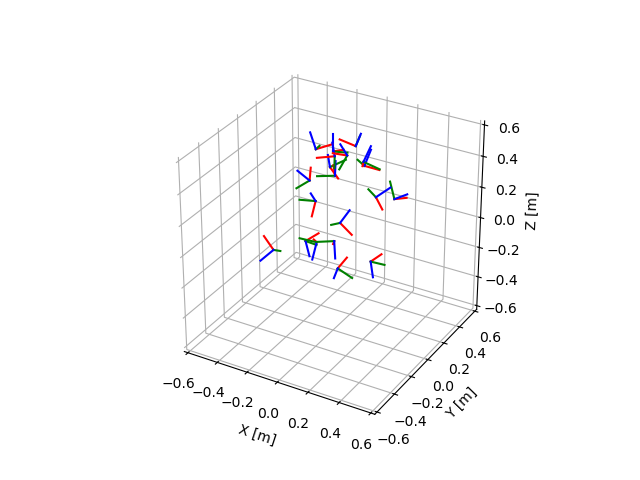

In [4]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import plot_basis
from pytransform3d.plot_utils import make_3d_axis

# Konstanten
AXIS_SCALE = 0.6
SAMPLE_SIZE = 20
POINT_SCALE = 1

fig = plt.figure()
ax = make_3d_axis(ax_s=AXIS_SCALE, unit="m", n_ticks=6)

samples = np.random.randint(0, len(tcp), SAMPLE_SIZE)
for i in samples:
    point = tcp[i][3::4] * POINT_SCALE
    rot = np.asarray([tcp[i][0:3], tcp[i][4:7], tcp[i][8:11]])
    plot_basis(ax, R=rot, p=point, s=0.1)

plt.show()

Mit der `probplot` Funktion von scipy können wir überprüfen ob die generierten Werte des Datahandlers einer Gleichverteilung folgen, dazu erstellt diese Funktion ein Wahrscheinlichkeitsdiagramm.

Ein Wahrscheinlichkeitsdiagramm ist ein grafisches Werkzeug zur Beurteilung, ob eine Datensatzverteilung einer theoretischen Verteilung folgt. Es tut dies, indem es die geordneten Datenwerte gegen die erwarteten Werte der entsprechenden Quantile der gewählten theoretischen Verteilung aufträgt. Wenn die Daten der theoretischen Verteilung folgen, sollten die Punkte im Diagramm ungefähr entlang einer geraden Linie liegen.

Sie werden sehen, dass dies bei 100 Werten nicht der Fall ist, sich mit steigendem `n` aber immer weiter der Linie annähert.

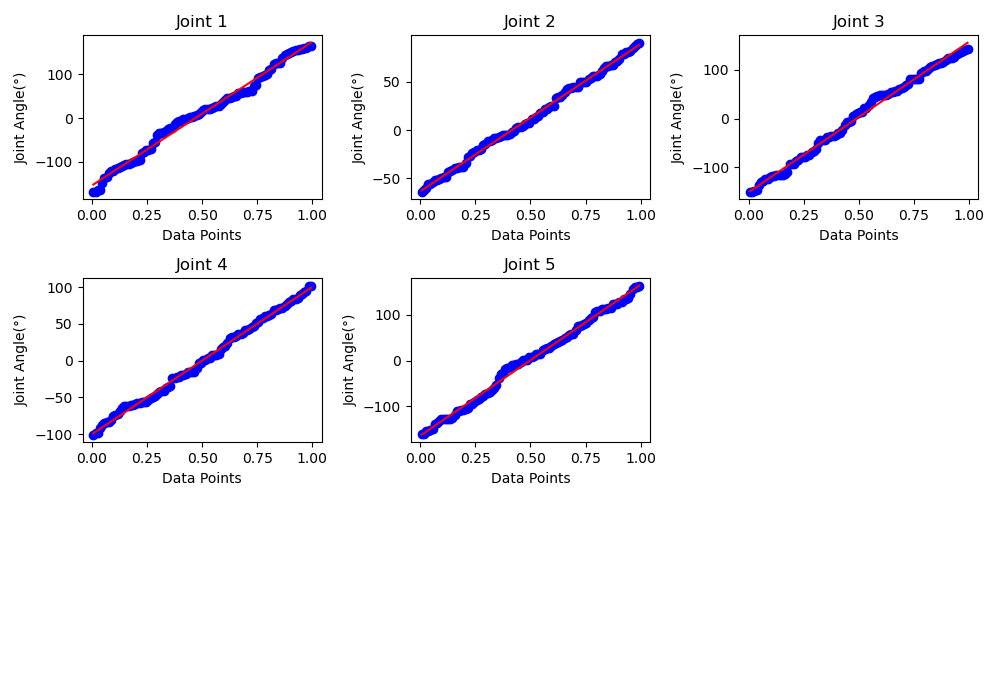

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

n_pos = datahandler.generate_n_positions(n=100)
num_cols = n_pos.shape[1]

subplot_side = int(np.ceil(np.sqrt(num_cols)))

fig, axs = plt.subplots(subplot_side, subplot_side, figsize=(10, 7))
axs = axs.flatten()

for i in range(num_cols):
    stats.probplot(n_pos[:, i], dist="uniform", plot=axs[i])
    axs[i].set_title(f'Joint {i+1}')
    axs[i].set_xlabel('Data Points')
    axs[i].set_ylabel('Joint Angle(°)')
    

# remove the extra subplots
for i in range(num_cols, subplot_side*subplot_side):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

Wenn wir alles richtig gemacht haben ist unser Datengenerator fertig, er liefert uns Eingabe und Ausgabe für das Netz. Für das Trainieren mit Supervised Learning brauchen wir beides. Die Eingabe(TCP) wird durch das Netz propagiert und liefert eine Ausgabe(Gelenkwinkelstellung), diese wird mit den erwarteten Gelenkwinkelstellungen für den TCP verglichen und ein Fehler ausgerechnet. Anhand dieses Fehlers kann das Netz über den Backpropagation-Algorithmus seine Gewichte einstellen.

Um es dem Netz etwas einfacher zu machen wird die Rotationsmatrix aus dem TCP in die speziellen Eulerwinkel *raw*, *pitch* und *yaw* überführt. Dies wird ebenfalls durch die Datahandler Klasse übernommen, dafür muss lediglich der Parameter <code>euler=True</code> gesetzt werden. Möchte man wieder mit TCP Frames arbeiten setzt man diesen auf <code>False</code>

In [6]:
datahandler.euler = True

Nun sollten wir uns im Vorfeld Gedanken darüber machen wie unser Netz aussehen sollte. Neben dem Input- und dem Output-Layer haben wir noch eine Anzahl an sogenannten Hidden-Layer. Die Anzahl der Units im Input- und Output-Layer sind klar definiert, aber im Hidden-Layer können beliebig viele Neuronen mit diesen Schichten verbunden werden. 

Wir benutzen PyTorch um das Netz aufzubauen, da es sich um ein einfaches Feed Forward Netz handeln soll benutzen wir die **Sequential()** Klasse von PyTorch um das Modell zu erstellen. Diesem Modell können nun Layer hinzugefügt werden analog zu unseren vorherigen Überlegungen. Ein Fully Connected Layer kann über die Klasse **Linear()** erstellt werden, wir definieren hier beispielsweise die Inputdimension(*in_features*), die Ausgangsdimension(*out_features*) und die Aktivierungsfunktion. Dieses Layer kann über <code>add_module</code> dem Model hinzugefügt werden. So kann man das Netz sehr einfach von vorne nach hinten aufbauen.

In [7]:
import torch
import torch.nn as nn

class IK_Solver(nn.Module):
    def __init__(self):
        super(IK_Solver, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=17, out_features=128, bias=False),
            nn.ReLU()
        )
        
        hidden_layers = 8
        for _ in range(hidden_layers):
            self.layers.add_module('hidden_layer_' + str(_), nn.Linear(128, 128))
            self.layers.add_module('activation_' + str(_), nn.ReLU())
        
        self.layers.add_module('output_layer', nn.Linear(128, 5, bias=False))
        self.layers.add_module('output_activation', nn.Tanh())
    
    def forward(self, x):
        return self.layers(x)

# Instantiate the model
model = IK_Solver()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Nun haben wir unsere Traningsdaten und unser Netz das trainiert werden soll. Bevor wir dieses trainieren können muss der Lernprozess konfiguriert werden. Dies geschieht über die <code>compile()</code> Funktion des Modells. Hier müssen noch der Optimierer und die Loss-Funktion übergeben werden.
Die Lossfunktion ermittelt wie der Fehler am Ausgang des Netzes berechnet wird, welcher minimiert werden soll. Der Optimierer ist für das Einstellen der Gewichte im Netz zuständig.
In diesem Fall nehmen wir den Adam Optimierer von Keras und den *mean squared error* als Loss Funktion.

In [8]:
import torch.optim as optim
# For a mean squared error regression problem
optimizer = optim.Adam(model.parameters(), lr=1.0e-4)
criterion = nn.MSELoss()

model.to(device)
model.train() # Set the model to train mode
print(f"Using device: {device}")

Using device: cuda


Man kann sich das kompilierte Modell in einer Tabelle anzeigen lassen.

In [9]:
print(model)

IK_Solver(
  (layers): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=False)
    (1): ReLU()
    (hidden_layer_0): Linear(in_features=128, out_features=128, bias=True)
    (activation_0): ReLU()
    (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
    (activation_1): ReLU()
    (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
    (activation_2): ReLU()
    (hidden_layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (hidden_layer_4): Linear(in_features=128, out_features=128, bias=True)
    (activation_4): ReLU()
    (hidden_layer_5): Linear(in_features=128, out_features=128, bias=True)
    (activation_5): ReLU()
    (hidden_layer_6): Linear(in_features=128, out_features=128, bias=True)
    (activation_6): ReLU()
    (hidden_layer_7): Linear(in_features=128, out_features=128, bias=True)
    (activation_7): ReLU()
    (output_layer): Linear(in_features=128, out_features=5, bias=False)

PyTorch gibt es in einer CPU und einer GPU Variante. Wenn man sich nicht sicher ist welche gerade in diesem Notebook läuft kann man es sich vorher nochmal ausgeben lassen. 

In [10]:
print("PyTorch Version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available")
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU not available")

PyTorch Version: 2.3.1+cu121
GPU is available
Device name:  NVIDIA GeForce GTX 1050 Ti


Wenn Sie CUDA über Anaconda installiert haben müssen Sie eventuell die Datei `env-prefix/etc/conda/activate.d/env_vars.sh` anlegen:

``` bash
#!/bin/sh

export LD_LIBRARY_PATH="$CONDA_PREFIX/lib"
```

Nun können wir endlich unser Modell trainieren. Vorher erzeugen wir uns noch einen neuen Datensatz. 100 Beispiele werden nicht reichen um ein zufriedenstellendes Ergebnis zu bekommen. Es sollten pro Durchlauf mindestens 100000 Datensätze erzeugt werden.
Um das Training zu starten rufen wir die <code>fit</code> Funktion des Modells auf. Dieser übergeben wir die Parameter ***x*** Input Daten, ***y*** Ziel Daten, ***epochs*** Anzahl an Durchläufen durch den gesamten Datensatz, ***batch_size*** Anzahl an Daten pro Update der Gewichte, ***validation_split*** prozentuale Aufteilung zwischen Trainingsdaten und Validierungsdaten.

Während des Trainings werden wir die Ausgabe des Netzes beobachten können, wir sehen den<code>loss</code>der aktuellen Epoche und ihren<code>val_loss</code>. Dies ist der ermittelte *mean squared error* der Lossfunktion für Trainingsdaten und Validierungsdaten. Dieser Fehler sollte eine abnehmende Tendenz aufweisen, dabei ist zu beachten dass der<code>val_loss</code> aussagekräftiger ist. Wenn der<code>loss</code> der Trainingsdaten wesentlich kleiner ist als der<code>val_loss</code>weist dies auf *Overfitting* hin, was bedeutet dass das Netz nicht generalisiert, sondern die Trainingsdaten "auswendig lernt".

In [14]:
from tqdm import tqdm
datahandler.compute_extreme_positions = True

samples = 250000
validation_split = 0.1
epochs = 10
K_epochs = 20
batch_size = 1000

for epoch in range(epochs):
    running_loss = 0.0
    # Generate some datapoints
    data, ground_truth = datahandler.generate_noised(samples)
    
    # Convert data to tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.float32)
    
    # Split data into train and val
    val_size = int(len(data) * validation_split)
    train_data_tensor = data_tensor[:-val_size]
    train_ground_truth_tensor = ground_truth_tensor[:-val_size]
    val_data_tensor = data_tensor[-val_size:]
    val_ground_truth_tensor = ground_truth_tensor[-val_size:]
    
    print(f"Training data size: {len(train_data_tensor)}")
    print(f"Validation data size: {len(val_data_tensor)}")
    
    # Move them to device
    train_data_tensor = train_data_tensor.to(device)
    train_ground_truth_tensor = train_ground_truth_tensor.to(device)
    val_data_tensor = val_data_tensor.to(device)
    val_ground_truth_tensor = val_ground_truth_tensor.to(device)

    for k_epoch in range(K_epochs):
        running_loss_k = 0.0
        tqdm_iterator = tqdm(range(0, len(train_data_tensor), batch_size), desc=f"Epoch {k_epoch+1}/{K_epochs}", leave=True)
        for i in tqdm_iterator:
            inputs = train_data_tensor[i:i+batch_size]
            labels = train_ground_truth_tensor[i:i+batch_size]
    
            optimizer.zero_grad()
    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss_k += loss.item()
    
            tqdm_iterator.set_postfix(loss=loss.item())
            
        k_epoch_loss = running_loss_k / len(train_data_tensor)
        running_loss += k_epoch_loss
        print(f"K_Epoch [{k_epoch+1}/{K_epochs}], Train Loss: {k_epoch_loss:.4f}")
    
        # Eval Step
        model.eval() # set model to validation mode
        with torch.no_grad():
            val_outputs = model(val_data_tensor)
            val_loss = criterion(val_outputs, val_ground_truth_tensor).item()
        print(f"K_Epoch [{k_epoch+1}/{K_epochs}], Validation Loss: {val_loss:.4f}")
        model.train() # Set model to train mode
    epoch_loss = running_loss / K_epochs
    print(f"Epoch: [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}")

Training data size: 225000
Validation data size: 25000


Epoch 1/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 306.35it/s, loss=0.258]


K_Epoch [1/20], Train Loss: 0.0004
K_Epoch [1/20], Validation Loss: 0.2593


Epoch 2/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 388.33it/s, loss=0.198]


K_Epoch [2/20], Train Loss: 0.0002
K_Epoch [2/20], Validation Loss: 0.1978


Epoch 3/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 389.02it/s, loss=0.153]


K_Epoch [3/20], Train Loss: 0.0002
K_Epoch [3/20], Validation Loss: 0.1551


Epoch 4/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 378.54it/s, loss=0.149]


K_Epoch [4/20], Train Loss: 0.0002
K_Epoch [4/20], Validation Loss: 0.1493


Epoch 5/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 376.45it/s, loss=0.146]


K_Epoch [5/20], Train Loss: 0.0001
K_Epoch [5/20], Validation Loss: 0.1462


Epoch 6/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 383.37it/s, loss=0.143]


K_Epoch [6/20], Train Loss: 0.0001
K_Epoch [6/20], Validation Loss: 0.1439


Epoch 7/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 383.86it/s, loss=0.142]


K_Epoch [7/20], Train Loss: 0.0001
K_Epoch [7/20], Validation Loss: 0.1420


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 387.22it/s, loss=0.14]


K_Epoch [8/20], Train Loss: 0.0001
K_Epoch [8/20], Validation Loss: 0.1403


Epoch 9/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 380.57it/s, loss=0.138]


K_Epoch [9/20], Train Loss: 0.0001
K_Epoch [9/20], Validation Loss: 0.1387


Epoch 10/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 412.12it/s, loss=0.137]


K_Epoch [10/20], Train Loss: 0.0001
K_Epoch [10/20], Validation Loss: 0.1373


Epoch 11/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 381.22it/s, loss=0.135]


K_Epoch [11/20], Train Loss: 0.0001
K_Epoch [11/20], Validation Loss: 0.1359


Epoch 12/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 387.22it/s, loss=0.134]


K_Epoch [12/20], Train Loss: 0.0001
K_Epoch [12/20], Validation Loss: 0.1345


Epoch 13/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 377.60it/s, loss=0.133]


K_Epoch [13/20], Train Loss: 0.0001
K_Epoch [13/20], Validation Loss: 0.1332


Epoch 14/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 382.54it/s, loss=0.131]


K_Epoch [14/20], Train Loss: 0.0001
K_Epoch [14/20], Validation Loss: 0.1318


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 396.22it/s, loss=0.13]


K_Epoch [15/20], Train Loss: 0.0001
K_Epoch [15/20], Validation Loss: 0.1303


Epoch 16/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 382.04it/s, loss=0.128]


K_Epoch [16/20], Train Loss: 0.0001
K_Epoch [16/20], Validation Loss: 0.1288


Epoch 17/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 385.15it/s, loss=0.126]


K_Epoch [17/20], Train Loss: 0.0001
K_Epoch [17/20], Validation Loss: 0.1272


Epoch 18/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 377.47it/s, loss=0.124]


K_Epoch [18/20], Train Loss: 0.0001
K_Epoch [18/20], Validation Loss: 0.1256


Epoch 19/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 385.39it/s, loss=0.122]


K_Epoch [19/20], Train Loss: 0.0001
K_Epoch [19/20], Validation Loss: 0.1239


Epoch 20/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 397.52it/s, loss=0.121]


K_Epoch [20/20], Train Loss: 0.0001
K_Epoch [20/20], Validation Loss: 0.1223


NameError: name 'epoch_loss' is not defined

So trainierte Modelle können über die Funktionen <code>save()</code> und <code>load_weights()</code> gespeichert und geladen werden. Achten Sie darauf, dass das Modell vorher initialisiert sein muss, falls Sie an der Struktur des Netzes etwas ändern wird die Funktion <code>load_weights()</code> das Modell nicht mehr laden können.
```python
torch.save(model.state_dict(), 'model_IK_noised.pt')
model.load_state_dict(torch.load('model_IK_noised.pt'))
```

In [12]:
torch.save(model.state_dict(), 'model_IK_noised.pt')

In [13]:
model.load_state_dict(torch.load('model_IK_noised.pt'))
model.eval()

IK_Solver(
  (layers): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=False)
    (1): ReLU()
    (hidden_layer_0): Linear(in_features=128, out_features=128, bias=True)
    (activation_0): ReLU()
    (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
    (activation_1): ReLU()
    (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
    (activation_2): ReLU()
    (hidden_layer_3): Linear(in_features=128, out_features=128, bias=True)
    (activation_3): ReLU()
    (hidden_layer_4): Linear(in_features=128, out_features=128, bias=True)
    (activation_4): ReLU()
    (hidden_layer_5): Linear(in_features=128, out_features=128, bias=True)
    (activation_5): ReLU()
    (hidden_layer_6): Linear(in_features=128, out_features=128, bias=True)
    (activation_6): ReLU()
    (hidden_layer_7): Linear(in_features=128, out_features=128, bias=True)
    (activation_7): ReLU()
    (output_layer): Linear(in_features=128, out_features=5, bias=False)

Nun wollen wir überprüfen ob unser Netz auch auf neuen Daten funktioniert. Dafür generieren wir uns wieder einige Daten. Die so generierten TCPs dienen wieder als Eingabe in unser Modell. Über die <code>predict()</code> Funktion können wir unsere Daten durch das Netz propagieren um eine Ausgabe zu erhalten. Was bislang verschwiegen wurde ist, dass die Daten bevor sie in das Netz gespeist wurden normalisiert waren, diese Normalisierung muss rückgängig gemacht werden, bevor wir weiter mit den Daten arbeiten können.

In [14]:
datahandler.compute_extreme_positions = False
input_, gt = datahandler.generate_noised(500)
input_ = torch.tensor(input_, dtype=torch.float32).to(device)
pred = model(input_).cpu().detach().numpy()
gen_pos = datahandler.denormalize(gt)
pred = datahandler.denormalize(pred)

Generierung der Gelenkwinkel: 0.00 Sekunden
DH Transformation: 0.05 Sekunden
Euler Winkel: 0.01 Sekunden
DH Transformation: 0.05 Sekunden
Euler Winkel: 0.01 Sekunden
Generierung des TCPs: 0.12 Sekunden
Normalisierung: 0.00 Sekunden
Gesamt:  0.12 Sekunden


Startpunkt ist immer [0,0,0....]

In [15]:
jpos_, tpos_, njpos_, ntpos_ = datahandler.generate_noised_data(500)
jpos_ = datahandler.normalize_joint_angles(jpos_)
njpos_ = datahandler.normalize_joint_angles(njpos_)
tpos_ = datahandler.normalize_tcp(tpos_)
ntpos_ = datahandler.normalize_tcp(ntpos_)
input_ = np.concatenate((jpos_, tpos_, ntpos_), axis=1)
input_ = torch.tensor(input_, dtype=torch.float32).to(device)

pred = model(input_).cpu().detach().numpy()
gen_pos = datahandler.denormalize(njpos_)
pred = datahandler.denormalize(pred)

Generierung der Gelenkwinkel: 0.00 Sekunden
DH Transformation: 0.05 Sekunden
Euler Winkel: 0.01 Sekunden
DH Transformation: 0.05 Sekunden
Euler Winkel: 0.01 Sekunden
Generierung des TCPs: 0.12 Sekunden


Zur Vorbereitung für die nächste Aufgabe definieren wir schon einmal eine Funktion <code>custom_error()</code>. Diese soll später dafür dienen den *mean squared error* als Loss Funktion abzulösen. Wir können mit dieser Funktion aber auch schon die Genauigkeit unseres Netzes errechnen.

Dazu wird für jede Ausgabe des Netzes noch einmal die Vorwärtstransformation durchgeführt um den TCP zu errechnen. Der korrekte TCP gilt hierbei als Vergleichswert. Dann werden die Punktkoordinaten und die Drehmatrix der beiden Frames isoliert. Für die Drehmatrix berechnen wir den *mean squared error* und für die beiden Punkte wird der euklidische Abstand berechnet. Anschließend werden beide Werte mit unterschiedlicher Gewichtung addiert um auf den neuen Fehler zu kommen.

In [15]:
def custom_error(y_gt, angles_pred, euler=True):

    tcp_out = datahandler.robot.buildDhTcpFrame(angles_pred)
    tcp_out = np.asarray(tcp_out.flatten())
    tcp_out = tcp_out[0 :12]
    tcp_out = datahandler.normalize_tcp(np.expand_dims(tcp_out, axis=0))  
    tcp_out = tcp_out.flatten()
    
    if not euler:
        xyz_gt = y_gt[3::4]
        xyz_pred = tcp_out[3::4]
        rot_gt = np.asarray([y_gt[0:3], y_gt[4:7], y_gt[8:11]]).flatten()
        rot_pred = np.asarray([tcp_out[0:3], tcp_out[4:7], tcp_out[8:11]]).flatten()
    else:
        xyz_gt = y_gt[0:3]
        xyz_pred = tcp_out[:3]
        rot_gt = y_gt[3:6]
        rot_pred = tcp_out[3:]
        
    mse = np.mean(np.sqrt((rot_gt - rot_pred) ** 2))
    dist = np.linalg.norm(xyz_gt - xyz_pred)
    
    err = 0.1 * mse + 0.9 * dist

    return err

In [16]:
def mean_error(y_gt, angles_pred):
    return np.mean(np.sqrt((y_gt - angles_pred) ** 2))

Wir iterieren über die Länge des Ausgangsvektors und kummulieren den Fehler auf, anschließend teilen wir ihn durch die Länge.

In [17]:
import numpy as np
cus_err = 0
mse = 0

for i in range(len(pred)):
    loss = custom_error(input_[:,11:][i], pred[i])
    cus_err += loss
    loss = mean_error(gen_pos[i], pred[i])
    mse += loss

print("median custom error: ", cus_err/len(pred))
print("median mse: ", mse/len(pred))

median custom error:  1.7864191207916218
median mse:  0.16477485858165733


Wir können uns nun für einzelne Werte die Roboterstellungen für *Ground Truth* und *Prediction* der Gelenkwinkelstellungen anzeigen lassen. Orange bildet hierbei die *Ground Truth* ab und grün die *Prediction*, so bekommen wir eine grapfische Repräsentation von dem was unser Netz gelernt hat.

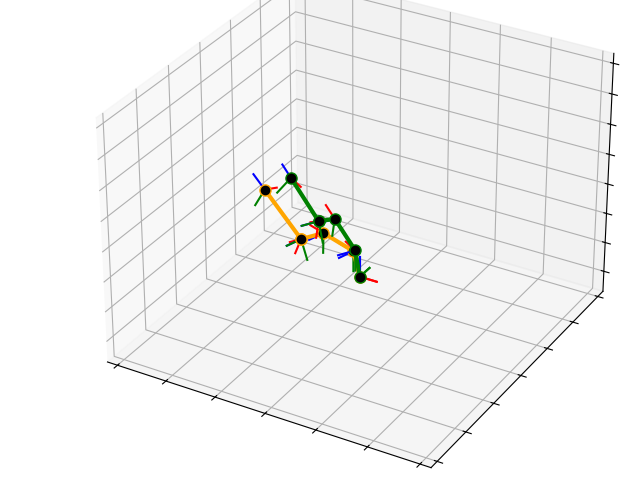

In [16]:
%matplotlib widget
from src.robotsimulation import RobotAnimation

drawer = RobotAnimation(Robot(robot='youbot'))
t = 50
#Nummer des Datensatzes
drawer.draw_robot([gen_pos[t], pred[t]])

Um einen noch besseren Eindruck zu bekommen ob unser Netz gut arbeitet können wir Gelenkwinkelpositionen generieren die eine bestimmte Trajektorie abfahren. Wir lassen uns die Trajektorie mit matplotlib ausgeben, wenden die Vorwärtstransformation auf unsere so generierten Gelenkwinkel an um den TCP zu bekommen. Diesen geben wir in unser trainiertes Netz und für den so generierten Ausgangsvektor der Gelenkwinkel lassen wir erneut die Trajektorie abfahren.

Als erstes generieren wir einfachhalber einen Gelenkwinkelvektor als numpy array.

In [17]:
start = np.array([169, -50, -20, -30, 0])

Ausgehend von unserem generierten Startwert können nun iterativ ausgewählte Werte des Vektors verändert werden um unterschiedliche Trajektorien abzufahren. Dabei sollte darauf geachtet werden die Gelenkwinkelgrenzen des YouBots einzuhalten.

In [18]:
arr = []
arr.append(start)
for i in range(52):
    start = np.copy(start)
    if(start[0]-6.5)>=datahandler.robot.joint_limits[0][1]:
        start[0] += -6
    arr.append(start)

arr = np.radians(np.asarray(arr))

Der so erzeugte Gelenkwinkelvektor kann der Funktion <code>draw_trajectory()</code> der Drawer Klasse übergeben werden um mit matplotlib eine animierte Trajektorie anzuzeigen.

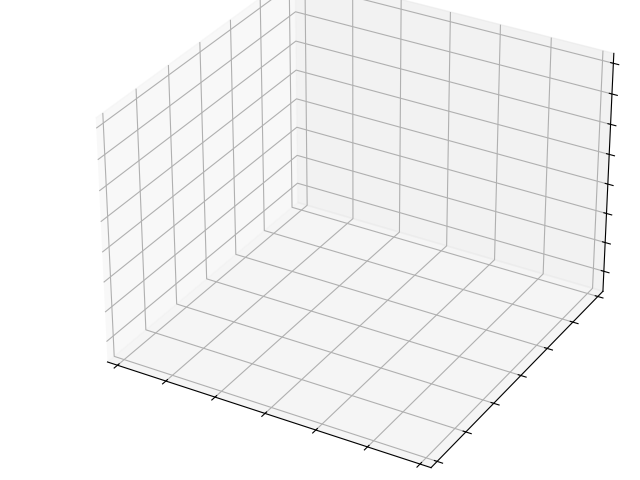

In [19]:
%matplotlib widget
    
drawer = RobotAnimation(robot=datahandler.robot)

drawer.draw_trajectory_robot(arr)

Wir erzeugen aus dem Gelenkwinkelvektor erneut die dazugehörigen TCP Frames und normalisieren sie anschließend, damit sie in das Netz gespeist werden können. Wir lassen uns über das Netz die berechneteten Gelenkwinkelstellungen ausgeben und denormalisieren diese.

In [20]:
arr_tcp = datahandler.calc_xyz_euler(arr)
arr_tcp = datahandler.normeuler(arr_tcp)

#Start positions and TCP
old_jpos = datahandler.normalize_joint_angles(np.radians(np.array([[169, -50, -20, -30, 0]])))
if not datahandler.euler:
    old_tcp = datahandler.calc_tcp(old_jpos)[0]
else:
    old_tcp = datahandler.calc_xyz_euler(old_jpos)[0]
    
old_jpos = old_jpos[0]
    
trajectory = []
for i, tcp in enumerate(arr_tcp):
    delta_tcp = np.subtract(tcp, old_tcp)
    input_ = np.expand_dims(np.concatenate((old_jpos, old_tcp, delta_tcp)), axis=0)
    input_ = torch.tensor(input_, dtype=torch.float32).to(device)
    output = model(input_).cpu().detach().numpy()
    old_jpos = output.flatten()
    old_tcp = tcp
    shape = datahandler.denormalize(output).flatten()
    trajectory.append(shape)
trajectory = np.asarray(trajectory)

DH Transformation: 0.01 Sekunden
Euler Winkel: 0.00 Sekunden
DH Transformation: 0.00 Sekunden
Euler Winkel: 0.00 Sekunden


Zum Schluss können wir die so erzeugen Gelenkwinkelpositionen erneut als Trajektorie abfahren lassen und bekommen so ein visuellen Vergleich zwischen Soll und Ist.

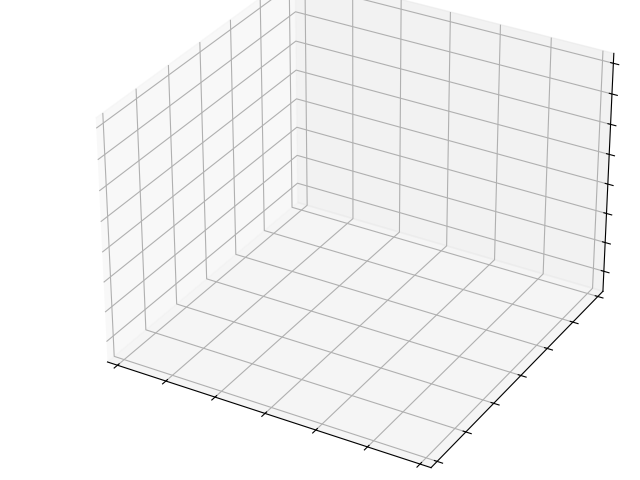

In [21]:
%matplotlib widget
drawer2 = RobotAnimation(robot=datahandler.robot)

drawer2.draw_trajectory_robot(trajectory)